# Computing Assignment 1
## Matthew King-Roskamp
## Student Number:

In [1]:
# Standard Preamble, importing necessary packages
import numpy as np;
import matplotlib.pyplot as pl;

# Part 1
## 1. Read the paper of Trefethen, Schrieber
This paper can be found e.g. on google scholar at
https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=average+case+stability+of+gaussian+elimination&btnG=&oq=average+case+stability+of+gaussian+elimin

Suppose $A$ has decomposition $PA = LU$ via GEPP. Part 1 is concerned with the behaivor of the growth factor

$$ g(A) = \frac{\max_{i,j} \vert u_{ij} \vert}{\max_{i,j} \vert a_{ij} \vert}$$.

## 2. Generation of Gaussian random matrices
Here, we generate square Gaussian matrices of a given size n.
We choose $\sigma = 1$, and $\mu =0$ for simplicity. However, this can easily be added as arguments of the function, If one wishes to examine their effects on later experiments.

In [2]:
def gaussianMat(n):
    # Given input n, returns a square Gaussian Matrix of size n by n
    G = np.zeros((n,n));
    mu = 0;
    sigma =1;
    G = np.random.normal(mu,sigma,(n,n));
    return [G];

We call this function once to see that it works as intended. Note 

In [3]:
G = gaussianMat(3);
print(G);

[array([[-0.48215299,  1.13988325,  2.76303962],
       [-0.88390138, -0.05089563,  0.36328418],
       [-0.52313234, -1.38990122, -0.17245195]])]


## 3. Implementaion of GEPP
In this section, we implement Gaussian elimination with partial pivoting. 
As this is a standard algorithm, we comment throughout on what each step is doing.

For the purposes of this assignment, we simply need the upper trangular part $U$, and not the full $PA =LU$ decomposition. This is due to the fact we are only examining the growth factor. However, we return all parts of this decomposition for flexible use if necessary.

In [11]:
def GEPP(A):
    # Perform the decomposition PA =LU given input matrix A.
    U = np.copy(A);
    n = U.shape;
    n = n[0];
    L = np.identity(n);
    P = np.identity(n);
    
    # Setup intermediate matrices
    for k in range(n):
        
        # Find the largest entry in the current column k, make this the pivot i
        i = k+np.argmax(np.abs(U[k:n,k]));
        # Note that argmax returns the largest index in k to n
        # But counts from 0 to n-k (thus we add k back)
        
        # Swap rows of U,L,P. Note we make copies while swapping to avoid pointer issues.
        swapRowU = np.copy(U[k,k:n]);
        U[k,k:n] = U[i,k:n];
        U[i,k:n] = swapRowU;

        swapRowL = np.copy(L[k,1:k]);
        L[k,1:k] = L[i,1:k];
        L[i,1:k] = swapRowL;
        
        swapRowP = np.copy(P[k,:]);
        P[k,:] = P[i,:];
        P[i,:] = swapRowP;
    
        # After pivoting, we perform a gaussian elimination step on the k-th row
        for j in range(k+1,n):
            L[j,k] = np.divide(U[j,k],U[k,k]);
            intermed = L[j,k]*U[k,k:n];
            U[j,k:n] = np.subtract(U[j,k:n], intermed);
        
    return [P,L,U];

Now, we sanity check that this method is performing as intended. Let us decompose some matrices, and check for: 
- L and U are lower / upper triangular
- The diagonal entries of L are 1
- PA = LU

For this check, we simply run the following code block on 3 by 3 matrices to visualize.

In [12]:
A = gaussianMat(3);
A = A[0];
[P,L,U] = GEPP(A);

# Should be the same
print(np.matmul(P,A));
print(np.matmul(L,U));

#check structure
print(L);
print(U);

[[-0.52381276  0.65304374 -0.83902834]
 [-0.38922815  0.01566034 -0.15985092]
 [ 0.46260194 -0.85127522  0.26411464]]
[[-0.52381276  0.65304374 -0.83902834]
 [-0.38922815  0.01566034 -0.15985092]
 [ 0.46260194 -0.85127522  0.26411464]]
[[ 1.          0.          0.        ]
 [ 0.74306733  1.          0.        ]
 [-0.88314369  0.58463929  1.        ]]
[[-0.52381276  0.65304374 -0.83902834]
 [ 0.         -0.46959513  0.46360363]
 [ 0.          0.         -0.74790885]]


## 4.Plotting the growth factor vs Matrix Size

Here, we compute the PA = LU decomposition, and numerically examine the growth rate. Due to machine limitations, we test for moderate values of $n$ (between 200 and 500 by steps of $10$), and do $50$ tests at each $n$. A more robust experiment would of course test larger $n$ and for more tests; but this will suffice to observe trends in the growth rate

In [13]:
nValues = range(200,510,10)
numTests = 50;

g = np.zeros((1,np.size(nValues)));
index = 0;
for n in nValues:
    
    for j in range(numTests):
        
        A = gaussianMat(n)[0];
        U = GEPP(A)[2];
        g[0,index] = g[0,index] + (np.max(np.abs(U))/np.max(np.abs(A)));
        
    g[0,index] = g[0,index]/numTests;
    index = index +1;

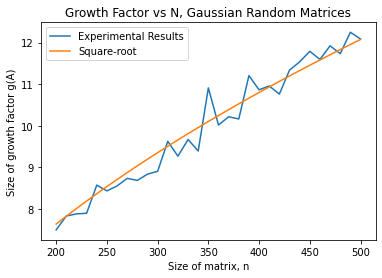

In [14]:
pl.plot(nValues,g[0,:]);
pl.xlabel('Size of matrix, n');
pl.ylabel('Size of growth factor g(A)');
pl.title('Growth Factor vs N, Gaussian Random Matrices');

# depending on the results, may need to tune C for a good fit. 
pl.plot(nValues, 0.54*np.sqrt(nValues));
pl.legend(['Experimental Results','Square-root']);

Here, we see that the growth rate is best fit by 

$$ g(A) \approx Cn^{\alpha}$$
Where $C \approx 0.5$ and $\alpha = 0.5$. That is, up to a constant, our average growth rate is

$$ g(A) \approx C\sqrt{n}. $$
This numerical observation is backed up by the theoretical result in the source paper of Trethen and Schrieber, wherein they **show** the expected average growth rate $\sim \sqrt{n}$. Thus, this is the result we expect.

## 5. Measuring the probability density of g for fixed n

Now, we switch our experiments. We perform this for several small $n$, here $n=10,20, 40,80. $ For each $n$, we find the growth factor for *many* matrices $A$, here $2000$ for each $n$. Then, we plot a histogram of the growth factors observed. Our binning strategy is to take $\sqrt{n}$ bins, so that we expect $\sqrt{n}$ entries in each bin for a uniform distribution. The vertical axis is scaled to log(frequency) as given in the question.

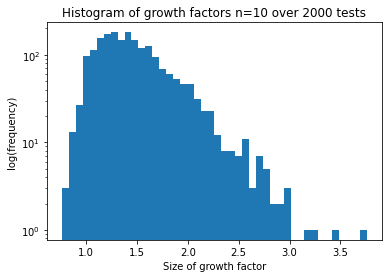

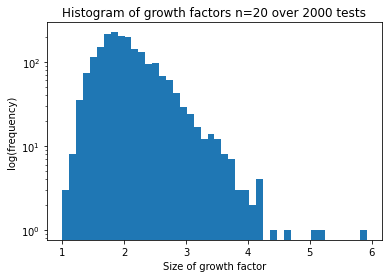

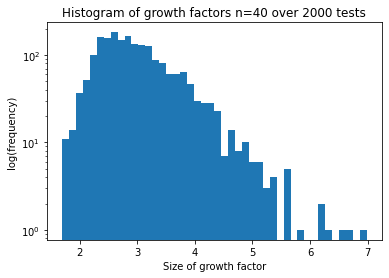

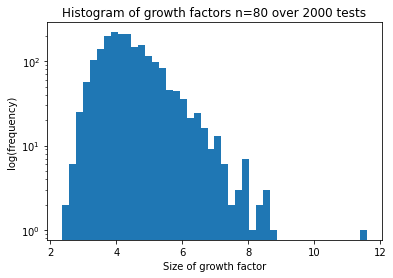

In [15]:
nVals = [10,20,40,80]
for n in nVals:
    numTests = 2000;
    g = np.zeros((1,numTests));
    for i in range(numTests):
        A = gaussianMat(n)[0];
        U = GEPP(A)[2];
        g[0,i] = g[0,i] + (np.max(np.abs(U))/np.max(np.abs(A)));

    pl.figure()
    pl.hist(g[0],density = False, bins = int(np.floor(np.sqrt(numTests))),log = True);
    pl.xlabel('Size of growth factor')
    pl.ylabel('log(frequency)')
    pl.title('Histogram of growth factors n=' +str(n)+ ' over ' + str(numTests) +' tests');

Here we can an important observation: Each of these experiments, in log scale, seem to have linear decay as the size of the growth factor $\to + \infty$. That is, we conjecture that probability density of growth factors decays exponentially fast for each fixed $n$. 

# Part 2 
In this section, we examine numerically the behaivor of Gradient Descent and Conjugate Gradient. First, we must implement these two methods. Much as before, these are standard, and thus we comment sparingly in the code itself.

## 1. Steepest Descent (SD) Implementation:

In [16]:
def steepestDesc(A,b,iterate,x0):
    # Define the parameters n,x,r : these will change every iteration
    n = A.shape[0];
    x = np.copy(x0);
    r = np.zeros((n,1))
    
    rNorm = np.zeros((iterate,1));
    
    for k in range(iterate):
        # Gradient descent step x_{k} = x_{k-1} + alpha_{k}r_{k-1}.
        r= -np.matmul(A,x) +b;
        rNorm[k,0] = np.linalg.norm(r);
        x = x + (np.matmul(np.transpose(r),r))/(np.matmul(np.matmul(np.transpose(r),A),r))*r;
        
    return rNorm

## 2. Implementation of (CG) Conjugate Gradient


In [17]:
def CG(A,b,iterate,x0):
    n = A.shape[0]; 
    x = np.copy(x0);
    
    r = np.copy(b);
    rNorm = np.zeros((iterate,1));
    trueRes =np.zeros((iterate,1));
    
    p = np.copy(r);
    
    for i in range(iterate):
        alpha = (np.matmul(np.transpose(r),r))/(np.matmul(np.matmul(np.transpose(p),A),p))
        x = x + alpha*p;
        rLast = np.copy(r);
        r = r - alpha*(np.matmul(A,p));
        beta = (np.matmul(np.transpose(r),r))/(np.matmul(np.transpose(rLast),rLast));
        p = r + beta*p;
        
        rNorm[i,0] = np.linalg.norm(r);
        trueRes[i,0] = np.linalg.norm(b - np.matmul(A,x));
        
    return [rNorm,trueRes];

## 3. Numerical examination of these methods
We now examine the convegence of both of these methods. For this, we run $i =1, \ldots,1000$ iterations of each of CG and SD, comparing against the predicted convergence rate of 

$$ \frac{2 (\sqrt{\kappa}-1)^{i}}{ (\sqrt{\kappa}+1)^{i}} $$.

For this, we use the tridiagonal matrix $A \in \mathbb{R}^{1000 \times 1000}$ with diagonal entries $1,2,\ldots, 1000$, and 1's above and below the main diagonal. The right hand side of the linear system $Ax = b $ is  $b = (1,1, \ldots 1)$. A quick estimate of $\kappa{A} \approx 4000$ shows that this problem is quite ill conditioned. Thus, we expect SD to converge slowly, and CG to converge faster.

For SD, we plot the computed (and true) norm of the residual $\Vert r_{i} \Vert_{2}$.

For CG, we plot the computed norm of the residual $\Vert r_{i} \Vert_{2}$, as well as the true residual $\Vert Ax_{i} - b \Vert_{2}$.

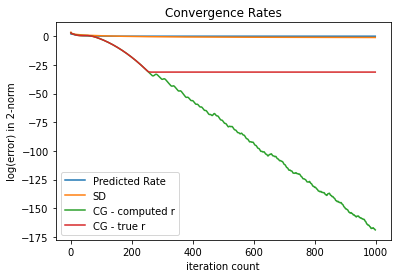

In [18]:
# Generating Matrix and RHS
A =np.diag(range(1,1001))+ np.diag(np.ones(999),-1) +np.diag(np.ones(999),+1) ;
b= np.ones((1000,1));
x0 = np.zeros((1000,1));

# Setting number of iterations
iterations = 1000;

#plot of predicted rate
kappa = np.linalg.cond(A);
plotKappa = np.zeros((1,iterations));
for i in range(iterations):
    plotKappa[0,i] = 2*((np.sqrt(kappa)-1)/(np.sqrt(kappa)+1))**i;
pl.plot(range(iterations),plotKappa[0]);

# Perform and plot SD
rNorm = steepestDesc(A,b,iterations,x0);
pl.plot(range(iterations),np.log(rNorm));

# Perform and plot CG
[rNorm,trueRes] =CG(A,b,iterations,x0)
pl.plot(range(iterations),np.log(rNorm));
pl.plot(range(iterations),np.log(trueRes));

pl.title('Convergence Rates');
pl.ylabel('log(error) in 2-norm');
pl.xlabel('iteration count');
pl.legend(['Predicted Rate','SD','CG - computed r','CG - true r']);

## 4. Commentary on these results.

There are several interesting observations to be had on this plot:
- Steepest descent and the predicted rate are extremely slow to converge. On this log plot, these never reach machine epsilon, even after 1000 iterations.
- The *computed* residual norm for CG is decreasing, even at a very high number of iterations. Of course, this is nonsense beyond machine $\epsilon$. But this is also deceiving is that the true residual ceases to decrease beyond iteration $\sim 250$. 
- The CG method far surpasses the expected convergence rate, even in this highly ill-conditioned example. This is a very big drawing point of this method, as it wholly outperforms SD.